# Homework4 --RNN

In [30]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, SimpleRNN, Dropout

# Load data
## the dataset is too large, to decrease the computing time, we use the weekly sale data of store 1



In [2]:
src_clean = '../content/clean_data.zip'
df_clean = pd.read_csv(src_clean,compression="zip")
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.loc[(df_clean.Store == 1)]
df_clean.set_index('Date', inplace=True)

df_clean.head()

,Unnamed: 0,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0,1,1,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,1,1,2,50605.27,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,2,1,3,13740.12,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,3,1,4,39954.04,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2010-02-05,4,1,5,32229.38,False,42.31,2.572,0.0,0.0,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010


In [76]:
df=df_clean.copy()
# Difference
#In this data, there are lots of same data values. So, I collect them together as weekly.
df_week = df.resample('W').mean() #resample data as weekly
df_week_sale = df_week['Weekly_Sales']


In [22]:
#Train-Test Split
train_data = df_week [:int(0.8*(len(df_week )))]
test_data = df_week [int(0.8*(len(df_week ))):]

In [24]:
def encoding_scaling(train, test):
  scaler_train = MinMaxScaler(feature_range=(0,1))
  train = scaler_train.fit_transform(train)
  scaler_test = MinMaxScaler(feature_range=(0,1))
  test = scaler_test.fit_transform(test)
  return scaler_train, train, scaler_test, test

In [25]:
scaler_train, train, scaler_test, test  = encoding_scaling(train_data, test_data)

In [17]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X), np.array(Y)

In [26]:
X_train, y_train = create_features(train, 1)
X_test, y_test = create_features(test, 1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (113, 1)  y_train shape: (113,) 
X_test shape: (28, 1)  y_test shape:  (28,)


In [27]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape, "\nX_test shape:", X_test.shape, " y_test shape: ", y_test.shape)

X_train shape: (113, 1, 1)  y_train shape: (113, 1) 
X_test shape: (28, 1, 1)  y_test shape:  (28, 1)


In [28]:
def RNN_create_and_fit_model(X_train,y_train, X_test, y_test, lookback=1, epochs=50, summary=True, fit=True):
  model = Sequential()
  model.add(SimpleRNN(units=50, activation="relu", input_shape=(X_train.shape[1], lookback)))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.compile(loss="mean_squared_error", optimizer="adam")
  callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=1, 
                      validation_data=(X_test, y_test), callbacks=callbacks, shuffle=False)
  
  return model, history

In [31]:
model, history = RNN_create_and_fit_model(X_train,y_train, X_test, y_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
101/113 [=========================>....] - ETA: 0s - loss: 0.0116
Epoch 1: val_loss improved from inf to 0.02810, saving model to mymodel.h5
113/113 [==============================] - 1s 4ms/step - loss: 0.0127 - val_loss: 0.0281
Epoch 2/50
 80/113 [====================>.........] - ETA: 0s - loss: 0.023

In [32]:
def RNN_model_evaluate(model):
  loss = model.evaluate(X_test, y_test, batch_size=1)
  print("Test Loss: %.2f" % (100 * loss))
  plt.figure(figsize=(10,5))
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16);

28/28 [==============================] - 0s 1ms/step - loss: 0.0016
Test Loss: 0.16


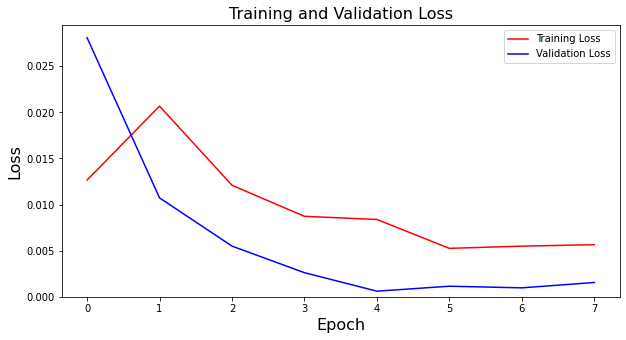

In [33]:
RNN_model_evaluate(model)

In [52]:
test_predict = model.predict(X_test)
test_predict = scaler_test.fit_transform(test_predict) 
y_train = scaler_train.fit_transform(y_train)
y_test = scaler_test.fit_transform(y_test)
RMSE_test = np.sqrt(mean_squared_error(y_test, test_predict))
print("############### Loss ###############")
print("\nRMSE Test: ", RMSE_test)

1/1 [==============================] - 0s 14ms/step
############### Loss ###############

RMSE Test:  0.028149333987169133


From the RMSE results, we can see that(ARIMA (RMSE = 0.098), VAR((RMSE = 0.099)), the RNN (RMSE = 0.028)get the best predict result. 